# XGBoost Classification - Explanation and Adance techniques

This notebook will progress through a classification problem of classifying NBA positions. The data set will have 5 NBA positions, or 5 categories. The models will progress from the most basic to more advanced techniques, focusing on hyperparameter optimization. Additionally, tools will be utilized to evaluate which features the models are using to produce their classifications.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

# this will be used to access the bigquery client
from google.cloud import bigquery
# this will be used to access the service account modules - passwords and access tokens
from google.oauth2 import service_account
# this will be used for returning data, increases the speed
from google.cloud import bigquery_storage
# for os library
import os

# required for certain returns
import pandas_gbq
# exception for a short script
from google.api_core.exceptions import NotFound

# Connect and query the data base from Google Cloud Platform

In [28]:
# Path to service account if stored locally
SERVICE_ACCOUNT_JSON = r"..\portfolio2026-485323-70c4d609b156.json"

# Credentials to access Big Query via the service account
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_JSON)

# BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# BigQuery Storage client
bq_storage_client = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Query the complete data set
query = """
SELECT *
FROM `portfolio2026-485323.portfolio1.df50`
"""

# Execute the query and use the bqstorage for faster data retrieval
df50 = client.query(query).to_dataframe(bqstorage_client=bq_storage_client)

# Dsiplay the data
display(df50.head())

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,drb,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl
0,469,Isaiah Stewart,C,19,DET,68,14,1455,226,409,...,294,453,59,39,86,67,184,537,2021,0.0
1,213,Jaxson Hayes,C,20,NOP,60,3,964,175,280,...,165,257,35,25,38,39,101,449,2021,0.0
2,381,Onyeka Okongwu,C,20,ATL,50,4,601,96,149,...,101,163,18,23,33,29,100,228,2021,0.0
3,94,Wendell Carter Jr.,C,21,TOT,54,44,1375,230,457,...,311,443,104,35,42,78,146,606,2021,0.0
4,425,Naz Reid,C,21,MIN,70,15,1347,304,581,...,240,322,72,34,76,69,179,784,2021,0.0


# Perform Classification using XGBoost

Classify the position of an NBA player. First we will remove the few players that have mixed positions.

In [29]:
df50['pos'].unique()

array(['C', 'C-PF', 'PF', 'PG', 'SF', 'SG', 'SG-SF', 'PF-SF', 'SF-SG',
       'SG-PG', 'SG-PG-SF', 'PF-C', 'PG-SG', 'SF-PF'], dtype=object)

In [30]:
df50['pos'].value_counts()

pos
SG          284
PF          227
PG          211
C           210
SF          209
SG-PG         4
SF-SG         4
SG-SF         2
C-PF          1
PF-SF         1
SG-PG-SF      1
PF-C          1
PG-SG         1
SF-PF         1
Name: count, dtype: int64

In [32]:
df50 = df50[df50['pos'].isin(['PG','SG','SF','PF','C'])].copy()

# We will utilize the X data and y data

X will consist of our numeric features
y will be a numeric encoding of the 'pos' categorical variable. There are 5 positions.

In [104]:
X = df50.copy() # label X for convention

# Encode the categorical target
le = LabelEncoder()
X.loc[:,'Pos_encoded'] = le.fit_transform(X.loc[:,'pos']) # type:ignore

y=X['Pos_encoded'].copy()

X = X.select_dtypes('number').copy()

X.drop(columns='Pos_encoded',inplace=True)

# XGBoost Classifier for NBA positions

Here I will utilize the XGBoost Classifier. The model is a tree model. It will progress by splitting the data multiple times based on features, such as above or below Feature 1 and the value of 10. The model will continue to split upon features to a depth parameter. The model will work to classify the data with the evaluation metric provided. 



Train, validation, and test splits are used for the data to prevent data leakage. The training data will be used to train the model. The model will then be validated on the validation data. So, during the training process the model will evaluate itself on the validation data. I will implement an early stopping round such that if the model doesn't improve on this validation data after 10 rounds the model will stop. This prevents the model from overfitting and continuing to train on the data past improvements.



In [59]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=10,
    eval_metric= 'mlogloss',              # multiclass log loss
    learning_rate=0.1, 
    max_depth=3,
    random_state=42                          
)  # for classification

# model = xgb.XGBRegressor()  # use this for regression tasks
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


# Make predictions and evaluate
y_pred = model.predict(X_test)

# Evaluate (choose the right metric)
print("Accuracy:", accuracy_score(y_test, y_pred))
# For regression: print("MSE:", mean_squared_error(y_test, y_pred))

Accuracy: 0.5676855895196506


In [60]:
probs = model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [61]:
np.round(probs, decimals=2)[:10]

array([[0.01, 0.18, 0.18, 0.25, 0.38],
       [0.01, 0.15, 0.02, 0.74, 0.08],
       [0.5 , 0.45, 0.01, 0.03, 0.01],
       [0.  , 0.05, 0.63, 0.01, 0.31],
       [0.2 , 0.47, 0.16, 0.12, 0.05],
       [0.  , 0.03, 0.21, 0.13, 0.62],
       [0.25, 0.27, 0.01, 0.34, 0.13],
       [0.05, 0.56, 0.01, 0.27, 0.11],
       [0.43, 0.25, 0.02, 0.21, 0.09],
       [0.01, 0.26, 0.02, 0.08, 0.63]], dtype=float32)

In [62]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Precision (macro): 0.566306517759713
Recall (macro): 0.5588486765581144
F1 Score (macro): 0.5554327362808567

Classification Report:
               precision    recall  f1-score   support

           C       0.80      0.71      0.76        52
          PF       0.41      0.43      0.42        46
          PG       0.66      0.69      0.68        36
          SF       0.44      0.27      0.33        41
          SG       0.52      0.69      0.59        54

    accuracy                           0.57       229
   macro avg       0.57      0.56      0.56       229
weighted avg       0.57      0.57      0.56       229



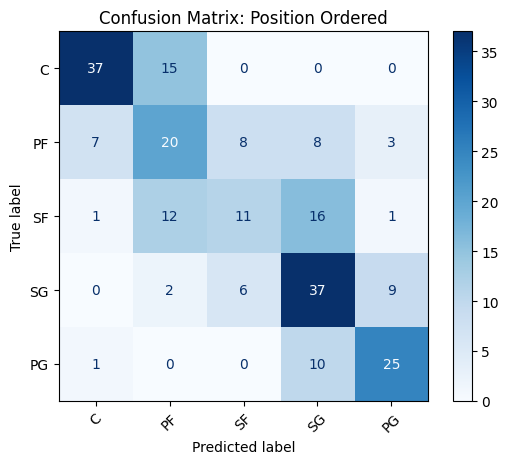

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()


In [64]:
# Class index 0 corresponds to this label:
print(le.inverse_transform([0,1,2,3,4]))  # e.g., ['C']

['C' 'PF' 'PG' 'SF' 'SG']


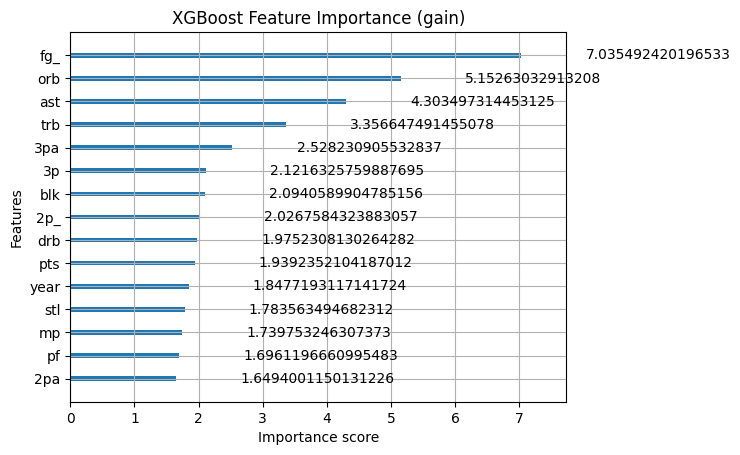

In [65]:
from xgboost import plot_importance

# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

In [43]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

display(importance_df.head(10))

,Feature,Importance
7,fg_,6.141193
18,orb,5.039865
21,ast,4.183451
9,3pa,3.941810
20,trb,3.357172
19,drb,2.577753
23,blk,2.508988
26,pts,2.499155
22,stl,2.158210
4,mp,2.131157


In [44]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Train dummy model
dummy = DummyClassifier(strategy='uniform')  # or 'stratified', 'uniform','most_frequent'
dummy.fit(X_train, y_train)

# Step 2: Predict and evaluate
y_dummy_pred = dummy.predict(X_test)

print("Dummy Model Accuracy:", accuracy_score(y_test, y_dummy_pred))
print("\nDummy Classification Report:\n", classification_report(y_test, y_dummy_pred, target_names=le.classes_))

Dummy Model Accuracy: 0.22707423580786026

Dummy Classification Report:
               precision    recall  f1-score   support

           C       0.37      0.27      0.31        52
          PF       0.23      0.22      0.22        46
          PG       0.13      0.17      0.15        36
          SF       0.24      0.24      0.24        41
          SG       0.19      0.22      0.21        54

    accuracy                           0.23       229
   macro avg       0.23      0.22      0.23       229
weighted avg       0.24      0.23      0.23       229



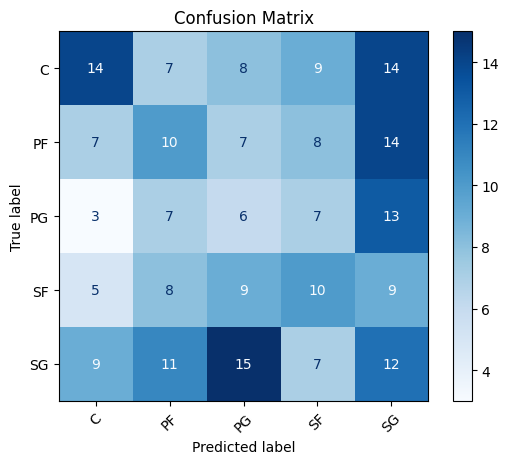

In [45]:
cm_dummy = confusion_matrix(y_test, y_dummy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dummy, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [46]:
import shap

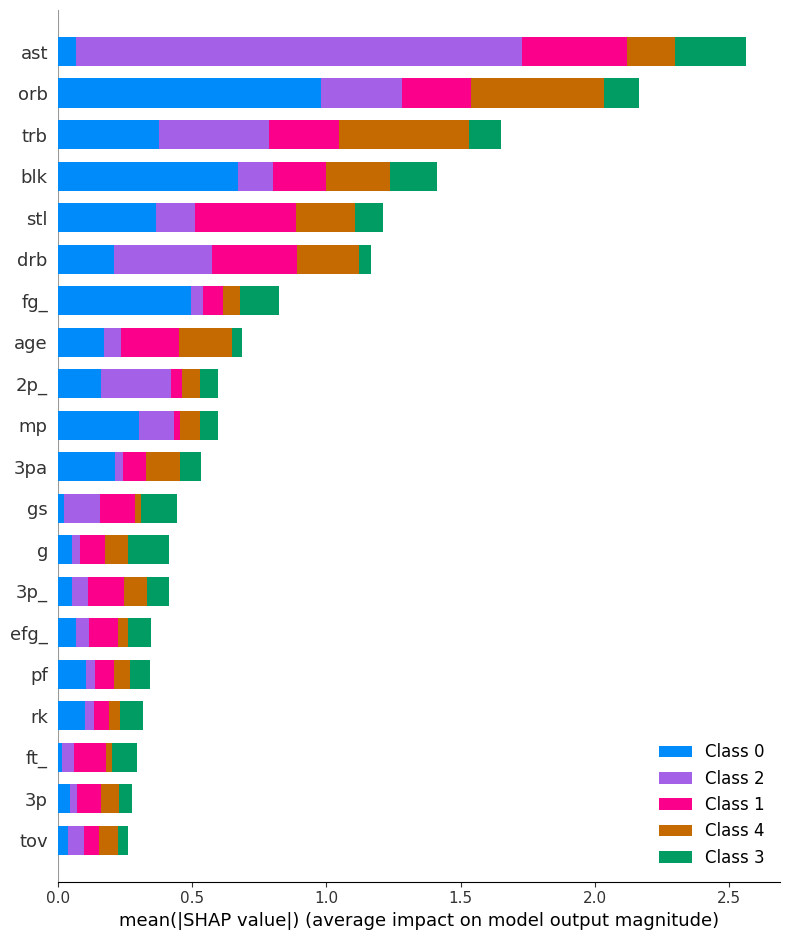

In [47]:
# Optional: silence warnings
import warnings
warnings.filterwarnings("ignore")

# Step 1: Create SHAP explainer
explainer = shap.Explainer(model)

#Step 2: Compute SHAP values
shap_values = explainer(X_test)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Now do the advanced techniques of cross validation and hyperparameter tuning

# Cross validation

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        early_stopping_rounds=20,
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)
    cv_scores.append(score)

print("CV Accuracy:", np.mean(cv_scores))


CV Accuracy: 0.6239676702673714


In [89]:
probs = model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [90]:
np.round(probs, decimals=2)[:10]

array([[0.01, 0.14, 0.11, 0.2 , 0.55],
       [0.01, 0.58, 0.02, 0.34, 0.06],
       [0.72, 0.26, 0.  , 0.02, 0.  ],
       [0.  , 0.03, 0.14, 0.02, 0.81],
       [0.05, 0.84, 0.04, 0.06, 0.02],
       [0.  , 0.01, 0.56, 0.05, 0.38],
       [0.04, 0.05, 0.01, 0.14, 0.75],
       [0.02, 0.82, 0.01, 0.1 , 0.05],
       [0.09, 0.2 , 0.02, 0.64, 0.06],
       [0.02, 0.22, 0.04, 0.1 , 0.63]], dtype=float32)

In [91]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Precision (macro): 0.9008563425370149
Recall (macro): 0.8860616387657746
F1 Score (macro): 0.890525294849571

Classification Report:
               precision    recall  f1-score   support

           C       0.96      0.90      0.93        52
          PF       0.75      0.85      0.80        46
          PG       0.97      0.92      0.94        36
          SF       0.94      0.78      0.85        41
          SG       0.88      0.98      0.93        54

    accuracy                           0.89       229
   macro avg       0.90      0.89      0.89       229
weighted avg       0.90      0.89      0.89       229



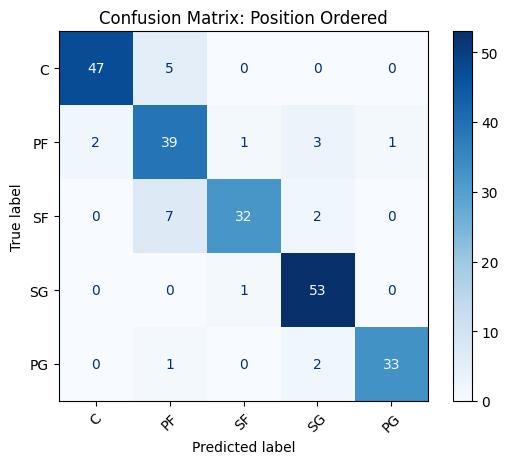

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()

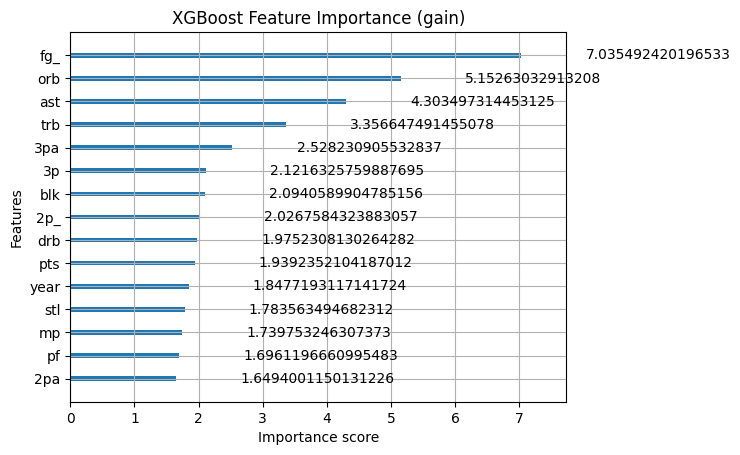

In [66]:
from xgboost import plot_importance

# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

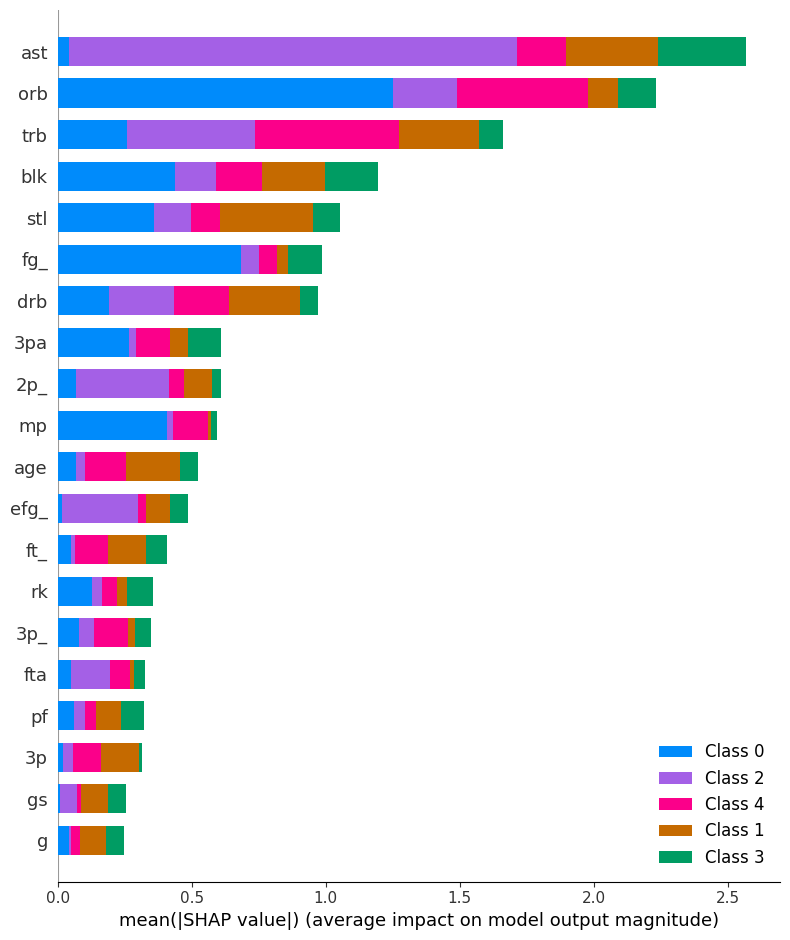

In [67]:
# Optional: silence warnings
import warnings
warnings.filterwarnings("ignore")

# Step 1: Create SHAP explainer
explainer = shap.Explainer(model)

#Step 2: Compute SHAP values
shap_values = explainer(X_test)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Now with Randomized Search and Cross Validation

When considering hyperparameter optimization, we must evaluate the number of combinations of hyperparameters. In this example we will use Randomized Search and utilize 30 different combinations of hyperparameters for efficiency. Using 6 hyperparameters and our value counts per hyperparameter there are 1296 combinations. Therefore, using grid search is not effective at scale for models with many hyperparameters. In this example, although we do perform the random search across the hyperparameters and cross validation, the results are worse than our initial inputs in the previous model.

We will use cross validation so each model will be fit across 5 train-test splits on the data. Considering our 30 different hyperparameter combinations we will produce 150 models. The cross validation will take the mean of each models 5 fits and produce the best parameters based on this metric. In this case, we are using accuracy for our scoring metric. Randomized search did not perform better than our previous model parameters. I did not utilize a technique to optimize the previous model hyperparameters.

Another issue with Random or Grid Search is that as the model utilizes different hyperparameter combinations, the process isn't adaptively learning about which parameter changes are driving improvement. The next step to find the best hyperparameter combinations and to scale is to use another library built for finding the best parameters. We will use the library optuna for a better method of searching hyperparameter space.

In [68]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(
    eval_metric="mlogloss",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV score: 0.6389067647284149


In [80]:
xgb_model = xgb.XGBClassifier(
    **search.best_params_,
    eval_metric="mlogloss",
    random_state=42
)


In [84]:
xgb_model.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,1.0
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_method

array([[0.01, 0.18, 0.18, 0.25, 0.38],
       [0.01, 0.15, 0.02, 0.74, 0.08],
       [0.5 , 0.45, 0.01, 0.03, 0.01],
       [0.  , 0.05, 0.63, 0.01, 0.31],
       [0.2 , 0.47, 0.16, 0.12, 0.05],
       [0.  , 0.03, 0.21, 0.13, 0.62],
       [0.25, 0.27, 0.01, 0.34, 0.13],
       [0.05, 0.56, 0.01, 0.27, 0.11],
       [0.43, 0.25, 0.02, 0.21, 0.09],
       [0.01, 0.26, 0.02, 0.08, 0.63]], dtype=float32)

Precision (macro): 0.5856724077413733
Recall (macro): 0.5757695782086026
F1 Score (macro): 0.5782350559703204

Classification Report:
               precision    recall  f1-score   support

           C       0.82      0.69      0.75        52
          PF       0.42      0.50      0.46        46
          PG       0.65      0.67      0.66        36
          SF       0.46      0.39      0.42        41
          SG       0.59      0.63      0.61        54

    accuracy                           0.58       229
   macro avg       0.59      0.58      0.58       229
weighted avg       0.59      0.58      0.58       229



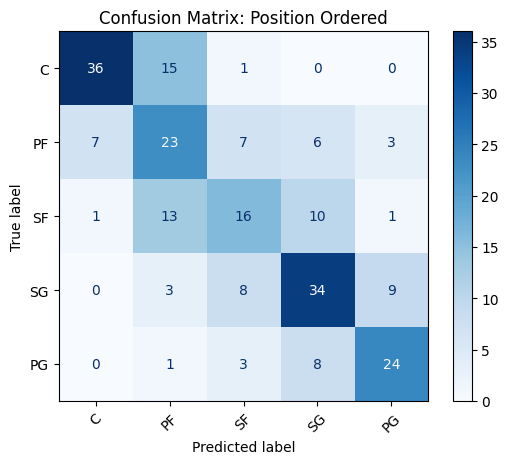

In [86]:
display(np.round(probs, decimals=2)[:10])

probs = xgb_model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()

In [25]:
# pip install optuna

If you can:

Explain why CV matters

Explain early stopping

Explain hyperparameter tradeoffs

You are already stronger than many entry-level candidates.

# Optuna and Hyperparameter Tuning

Optuna is an improvement on grid and randomized search becomes it adaptively learns from each trial. This means that the 30th trial has learned from the previous ones. This is based on the idea of the Optuna having an internal memory in its model that knows "Sample more like what already works, but don’t stop exploring". The model picks up on what parameters led to high performance metrics and continues to utilize those in future trials. In comparison to randomized search, randomized search jumps from parameter combination to parameter combination without considering the previous trials. 

In [26]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "eval_metric": "mlogloss",
        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)

        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best score:", study.best_value)


[I 2026-01-31 12:30:18,676] A new study created in memory with name: no-name-3bd6c6e9-6bfb-4d21-a74e-ac294eec866a
[I 2026-01-31 12:30:20,789] Trial 0 finished with value: 0.6291759964173756 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.12674370237247587, 'subsample': 0.7061764874350016, 'colsample_bytree': 0.9374429480135542, 'gamma': 0.45792391309823466}. Best is trial 0 with value: 0.6291759964173756.
[I 2026-01-31 12:30:24,037] Trial 1 finished with value: 0.6248731153903567 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.1672658876514035, 'subsample': 0.9948426294230955, 'colsample_bytree': 0.8428814152764803, 'gamma': 0.2691258642198059}. Best is trial 0 with value: 0.6291759964173756.
[I 2026-01-31 12:30:25,969] Trial 2 finished with value: 0.6274705179877594 and parameters: {'n_estimators': 304, 'max_depth': 5, 'learning_rate': 0.11093388515794174, 'subsample': 0.8925968292153905, 'colsample_bytree': 0.9048739561523171, 'gamma'

Best params: {'n_estimators': 608, 'max_depth': 7, 'learning_rate': 0.09407595705104552, 'subsample': 0.7305270624985976, 'colsample_bytree': 0.7487184952354125, 'gamma': 0.30198858619168695}
Best score: 0.6438908792357068


In [93]:
study.best_params

{'n_estimators': 608,
 'max_depth': 7,
 'learning_rate': 0.09407595705104552,
 'subsample': 0.7305270624985976,
 'colsample_bytree': 0.7487184952354125,
 'gamma': 0.30198858619168695}

In [97]:
xgb_model_optuna = xgb.XGBClassifier(
    **study.best_params,
    eval_metric="mlogloss",
    random_state=42
)


In [98]:
xgb_model_optuna.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.7487184952354125
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegress

In [100]:
probs = xgb_model_optuna.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [101]:
display(np.round(probs, decimals=2)[:10])

array([[0.  , 0.04, 0.03, 0.09, 0.84],
       [0.  , 0.86, 0.01, 0.12, 0.02],
       [0.91, 0.07, 0.  , 0.01, 0.  ],
       [0.  , 0.01, 0.05, 0.01, 0.93],
       [0.01, 0.96, 0.01, 0.01, 0.01],
       [0.  , 0.  , 0.87, 0.01, 0.11],
       [0.02, 0.01, 0.  , 0.03, 0.93],
       [0.01, 0.93, 0.  , 0.04, 0.01],
       [0.04, 0.04, 0.01, 0.88, 0.03],
       [0.01, 0.08, 0.01, 0.04, 0.86]], dtype=float32)

Precision (macro): 0.9271634900206329
Recall (macro): 0.9206164480819836
F1 Score (macro): 0.9214593967928396

Classification Report:
               precision    recall  f1-score   support

           C       0.96      0.90      0.93        52
          PF       0.80      0.93      0.86        46
          PG       0.95      0.97      0.96        36
          SF       0.97      0.83      0.89        41
          SG       0.96      0.96      0.96        54

    accuracy                           0.92       229
   macro avg       0.93      0.92      0.92       229
weighted avg       0.93      0.92      0.92       229



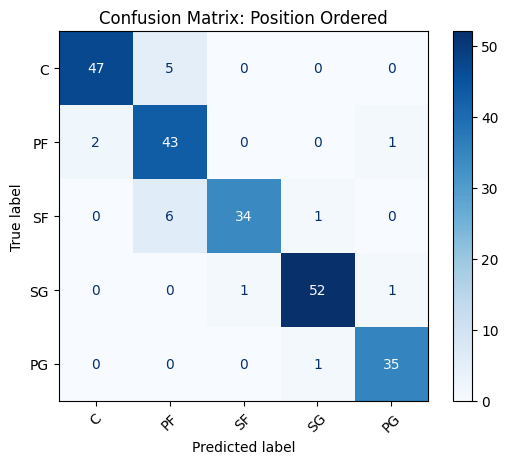

In [103]:
# Predictions
y_pred = xgb_model_optuna.predict(X_test)
y_proba = xgb_model_optuna.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()